<a href="https://colab.research.google.com/github/srv-sh/Pytorch_tutorial/blob/main/cifer10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train = True , download= True, transform= transform)
trainloader = torch.utils.data.DataLoader(trainset , batch_size= batch_size , shuffle = True, )
testset = torchvision.datasets.CIFAR10(root ='/.data', train = False , download= True,transform= transform)
testloader = torch.utils.data.DataLoader(testset , batch_size= batch_size, shuffle = True, )


Extracting ./data/cifar-10-python.tar.gz to ./data



Extracting /.data/cifar-10-python.tar.gz to /.data


In [3]:
classes = ('plane', 'car' ,'bird', 'cat', 'deer', 'dog' ,'frog','horse' ,'ship' , 'truck')

Let us show some of the training images, for fun

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
  img = img + .5 #UNNORMALIZE
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  car  cat  dog ship


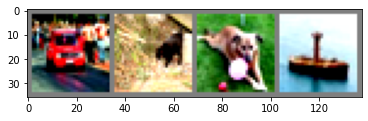

In [7]:
#get some random training images
dataiter = iter(trainloader)
images , labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images))
#print labels
print('' .join('%5s' % classes[labels[j]] for j in range(batch_size)))

# 2. Define a Convolutional Neural Network

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6,16,5)
    self.fc1 = nn.Linear(16*5*5 ,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
  def forward(self,x):
    x= self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x = x.view(-1,16*5*5)
    x= F.relu(self.fc1(x))
    x= F.relu(self.fc2(x))
    x= self.fc3(x)
    return x
net = Net()

# 3. Define a Loss function and optimizer
let's use a Classification Cross-Entropy loss and SGD with momentum

In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr =0.001, momentum = 0.9)

# 4. Train the network



In [10]:
for epoch in range(2): # LOOP over the dataset multiple times
  running_loss = 0.0
  for i , data in enumerate(trainloader, 0):
    # GET the input; data is a list of [inputs , labels]
    inputs , labels = data

    #zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimizer
    outputs = net(inputs)
    loss = criterion(outputs , labels)
    loss.backward()
    optimizer.step()

    #print statistics
    running_loss += loss.item()
    if i% 2000 == 1999: #print every 2000 mini- batches
      print('[%d , %5d] loss: %.3f' % (epoch +1 , i+1 , running_loss /2000))
      running_loss =0.0
print('Finished Training')


[1 ,  2000] loss: 2.195
[1 ,  4000] loss: 1.875
[1 ,  6000] loss: 1.681
[1 ,  8000] loss: 1.583
[1 , 10000] loss: 1.525
[1 , 12000] loss: 1.476
[2 ,  2000] loss: 1.407
[2 ,  4000] loss: 1.402
[2 ,  6000] loss: 1.346
[2 ,  8000] loss: 1.334
[2 , 10000] loss: 1.318
[2 , 12000] loss: 1.258
Finished Training


Let's quickly save our trained model

In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# 5. Test the network on the test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  deer   cat plane  deer


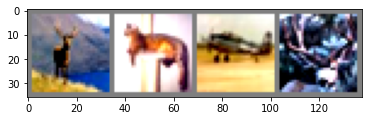

In [13]:
dataiter = iter(testloader)
images , labels = dataiter.next()

#print images 
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join('%5s'% classes[labels[j]] for j in range(4)))

let's load back in our saved model.

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

let us see what neural network thinks these examples above are

In [15]:
outputs = net(images)
outputs.shape

torch.Size([4, 10])

In [16]:
_ , predicted = torch.max(outputs,1)
print('Predicted: ',' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:   bird   cat horse  ship


Let us look at how the network performs on the whole dataset.

In [17]:
correct = 0 
total = 0
# since we' re not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
  for data in testloader:
    images , labels = data
    #calculate outputs by running images through the network
    outputs = net(images)
    # the class with highest energy is what we choose as prediction
    _ , predicted = torch.max(outputs.data , 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images %d %%' % (100  * correct / total))



Accuracy of the network on the 1000 test images 55 %


Thats looks wy better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). seems like the network learnt something.

hmmmmmm, what are the classes that performed well, and the classes that did not perform well

In [25]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname :0 for classname in classes}

#again no needed
with torch.no_grad():
  for data in testloader:
    images , labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs , 1)
    # collect the correct predictions for each class
    for label , prediction in zip(labels , predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

#print accuracy for each class
for classname , correct_count in correct_pred.items():
  accuracy = 100 * (correct_count / total_pred[classname])
  print("Accuracy for class {:5s} is : {:.1} %".format(classname , accuracy))

Accuracy for class plane is : 6e+01 %
Accuracy for class car   is : 6e+01 %
Accuracy for class bird  is : 4e+01 %
Accuracy for class cat   is : 5e+01 %
Accuracy for class deer  is : 4e+01 %
Accuracy for class dog   is : 5e+01 %
Accuracy for class frog  is : 6e+01 %
Accuracy for class horse is : 7e+01 %
Accuracy for class ship  is : 8e+01 %
Accuracy for class truck is : 7e+01 %


# Training on GPU

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [27]:
#The rest of this section assumes that device is a CUDA device.
net.to(device)
#Remember that you will have to send the inputs and targets at every step to the GPU too:

inputs, labels = data[0].to(device), data[1].to(device)
